# Building a Non End-to-End network with Madrax

In this tutorial we will explain how to build a classical non End-to-End neural network with MadraX. 

With non End-to-End we mean an application in which MadraX is calculated at the very beginning of the training loop and it is not included in the back-propagation.

Let's start again with all the imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
from madrax.ForceField import ForceField # the main MadraX module
from madrax import utils,dataStructures # the MadraX utility module
import time,os,urllib,torch


and then let's download some example structures to use as input. 

In [2]:
if not os.path.exists("exampleStructuresNet"):
    os.mkdir('exampleStructuresNet')
    
urllib.request.urlretrieve('http://files.rcsb.org/download/1LYI.pdb', 'exampleStructuresNet/1LYI.pdb')
urllib.request.urlretrieve('http://files.rcsb.org/download/1QTC.pdb', 'exampleStructuresNet/1QTC.pdb')
urllib.request.urlretrieve('http://files.rcsb.org/download/1WQO.pdb', 'exampleStructuresNet/1WQO.pdb')

('exampleStructuresNet/1WQO.pdb', <http.client.HTTPMessage at 0x7f696bc5d970>)

as in the quickstart tutorial, we need to parse and precalculate the information tensors and generate the MadraX main object (see quickstart for a step to step guide)

In [3]:
device = "cpu"
coords, atnames, pdbNames = utils.parsePDB("exampleStructuresNet/") # get coordinates and atom names

info_tensors = dataStructures.create_info_tensors(atnames,device=device)
forceField_Obj = ForceField(device=device)

Let's calculate the energy of the proteins just running MadraX

In [4]:
energies = forceField_Obj(coords.to(device), info_tensors).data # we don't need the gradient

print(energies.shape)


torch.Size([3, 1, 163, 1, 11])


We have 3 single chain proteins, with a maximum of 163 residues.

We now want to build a neural network that gives a per-residue prediction. First of all, lets get the sequence of the input structures, so that we can get the length of each protein.

In [5]:
seqs = utils.atomName2Seq(atnames)
lens = [len(i) for i in seqs]

Let's generate some random binary labels. They represent the task we want to predict. Every residue is going to be associated with a label (0 or 1). The padding will be assigned with a -1


In [6]:
y=[]
for i in lens:
    y += [torch.randint(high=2,low=0,size = [i],device=device).float()]

paddedY = torch.nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=-1)

We now need a very simple neural network which can handle sequences of different length. 

Let's make a standard LSTM followed by a Feed Forward net. 

Remember this is just an example and more complex architecture are going to be required to address most of the real world structural problems.

In [7]:
class SimpleNN(torch.nn.Module): # very simple recurrent neural net

    def __init__(self,hidden_sizeRNN=50,num_layersRNN=3,hidden_feedForward = 50,device="cpu"):

        super(SimpleNN, self).__init__()

        self.recurrent = torch.nn.LSTM(11, hidden_sizeRNN, num_layersRNN, bidirectional=True,device=device,batch_first=True)

        self.feedForwardStep = torch.nn.Sequential(
                                                torch.nn.Linear(hidden_sizeRNN*2, hidden_feedForward),
                                                torch.nn.Tanh(),
                                                torch.nn.Linear(hidden_feedForward, hidden_feedForward),
                                                torch.nn.Tanh(),
                                                torch.nn.Linear(hidden_feedForward, 1),
                                                torch.nn.Sigmoid()
                                                ).to(device)

    def forward(self,energies):
        input_RNN = energies[:,0,:,0,:]# let's assume, for simplicity, we only have single chain proteins
        output_RNN,_ = self.recurrent(input_RNN) # application of the recurrent step
        out = self.feedForwardStep(output_RNN) # application of the feed forward step
        return out.squeeze(-1)

Let's create the network objects that are required for the training (network object, optimizer and loss function)

In [8]:
model = SimpleNN(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = torch.nn.BCELoss()

And now the training loop.

In [9]:
old_time = time.time()
for epoch in range(501):
    
    prediction = model(energies)

    padding_mask = paddedY>=0 #we remove the padding from the loss evaluation
    loss = loss_function(prediction[padding_mask],paddedY[padding_mask])
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch%50==0:
        print("epoch",epoch,"loss:",round(float(loss.sum().cpu().data),4),"time:",round(time.time()-old_time,3))
        old_time = time.time()

epoch 0 loss: 0.6974 time: 0.195
epoch 50 loss: 0.6917 time: 11.268
epoch 100 loss: 0.6913 time: 11.121
epoch 150 loss: 0.69 time: 12.471
epoch 200 loss: 0.6657 time: 14.519
epoch 250 loss: 0.6402 time: 16.358
epoch 300 loss: 0.6059 time: 16.181
epoch 350 loss: 0.574 time: 16.087
epoch 400 loss: 0.5486 time: 11.542
epoch 450 loss: 0.5214 time: 12.357
epoch 500 loss: 0.4945 time: 14.276


After the training, we can use the model to make predictions and calculate the performances. In order to plot a ROC curve we will use sklearn and matplotlib

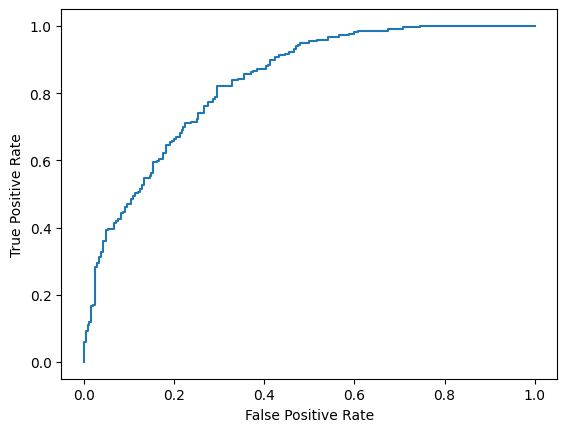

In [10]:
predicted_labels = model(energies)

from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(paddedY[padding_mask].cpu().data.tolist(), predicted_labels[padding_mask].cpu().data.tolist()) # false and true positive rates

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Now, before starting your personal dance of victory for the successful training of the network, remember you will need a proper cross-validation in real case applications!